Нормализация данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os

df = pd.read_csv(os.path.join('..', '..', 'data', 'ForUbung', 'trip_duration_task.csv'))

df['vendor_id'] = df['vendor_id'].fillna(1)
df['vendor_id'] = df['vendor_id'].astype(int)

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']).map(pd.Timestamp.timestamp)
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime']).map(pd.Timestamp.timestamp)

group = df.groupby('dropoff_latitude')['pickup_latitude'].transform('median').median()
df['pickup_latitude'] = df['pickup_latitude'].fillna(group)

null_passeger = df.loc[df['passenger_count'] == 0]

df = df.drop(index=null_passeger.index)

del_latidute = (np.pi / 180) * (df['dropoff_latitude'] - df['pickup_latitude'])
mean_latidude = (df['dropoff_latitude'] + df['pickup_latitude']) / 2
del_longitude = (np.pi / 180) * (df['dropoff_longitude'] - df['pickup_longitude'])

distance = pd.DataFrame(6371 * np.sqrt(np.power(del_latidute, 2) + np.power(np.cos(mean_latidude) * del_longitude, 2)))
df['distance'] = distance

df['id'] = df['id'].transform(lambda x: x.str[2:]).astype(int)

In [2]:
from sklearn.model_selection import train_test_split

X = df.drop('trip_duration', axis=1)
Y = df[['trip_duration']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, random_state=42)

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

Tree_regressor = DecisionTreeRegressor(max_depth=3)
Tree_regressor.fit(X_train, y_train)

y_predict = Tree_regressor.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_predict), 
      '\nR^2= ',
      Tree_regressor.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_predict),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_predict),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_predict))
      )

MSE =  9491812.972368121 
R^2=  0.02333880886608497 
MAE =  448.1706158868883 
MAPE =  0.9139871390917189 
RMSE =  3080.8786039648044


In [4]:
from sklearn.model_selection import cross_val_score

path = DecisionTreeRegressor(max_depth=3).cost_complexity_pruning_path(X_train,y_train)
ccp_alphas = path.ccp_alphas

In [5]:

RMSE_CV=[]
for alpha in ccp_alphas:
    MSE = -cross_val_score(estimator = DecisionTreeRegressor(random_state=1,ccp_alpha=alpha, max_depth=3), X = X_train, y = y_train, cv = 5 , scoring="neg_mean_squared_error" )
    RMSE_CV.append(np.sqrt(MSE).mean())

output = pd.DataFrame(list(ccp_alphas), columns=['alpha'])
output['RMSE_CV']=RMSE_CV

output.head()

,alpha,RMSE_CV
0,0.000000,4062.693158
1,9932.927032,4063.215944
2,19644.278659,4063.216426
3,20130.329326,4063.216426
4,42753.159465,4061.491515


In [6]:
optimal_alpha = output.iloc[np.argmin(output['RMSE_CV']),][0]

optimal_DT = DecisionTreeRegressor(ccp_alpha=optimal_alpha, max_depth=3)
optimal_DT.fit(X_train, y_train)
y_hat_opt = optimal_DT.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_hat_opt), 
      '\nR^2= ',
      optimal_DT.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_hat_opt),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_hat_opt),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_hat_opt))
      )

C:\Users\ktulu\AppData\Local\Temp\ipykernel_17204\801236972.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  optimal_alpha = output.iloc[np.argmin(output['RMSE_CV']),][0]


MSE =  9484975.244178718 
R^2=  0.02404237769719808 
MAE =  459.166918268783 
MAPE =  0.9249388555988161 
RMSE =  3079.7686997855403


In [7]:
X_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance'],
      dtype='object')

[Text(0.6, 0.8333333333333334, 'x[9] <= 6.161\nsquared_error = 20153249.61\nsamples = 364644\nvalue = 955.988'),
 Text(0.4, 0.5, 'x[9] <= 2.264\nsquared_error = 9254199.785\nsamples = 308239\nvalue = 768.518'),
 Text(0.2, 0.16666666666666666, 'squared_error = 8776953.191\nsamples = 174963\nvalue = 565.088'),
 Text(0.6, 0.16666666666666666, 'squared_error = 9755073.96\nsamples = 133276\nvalue = 1035.578'),
 Text(0.8, 0.5, 'squared_error = 78472181.243\nsamples = 56405\nvalue = 1980.463')]

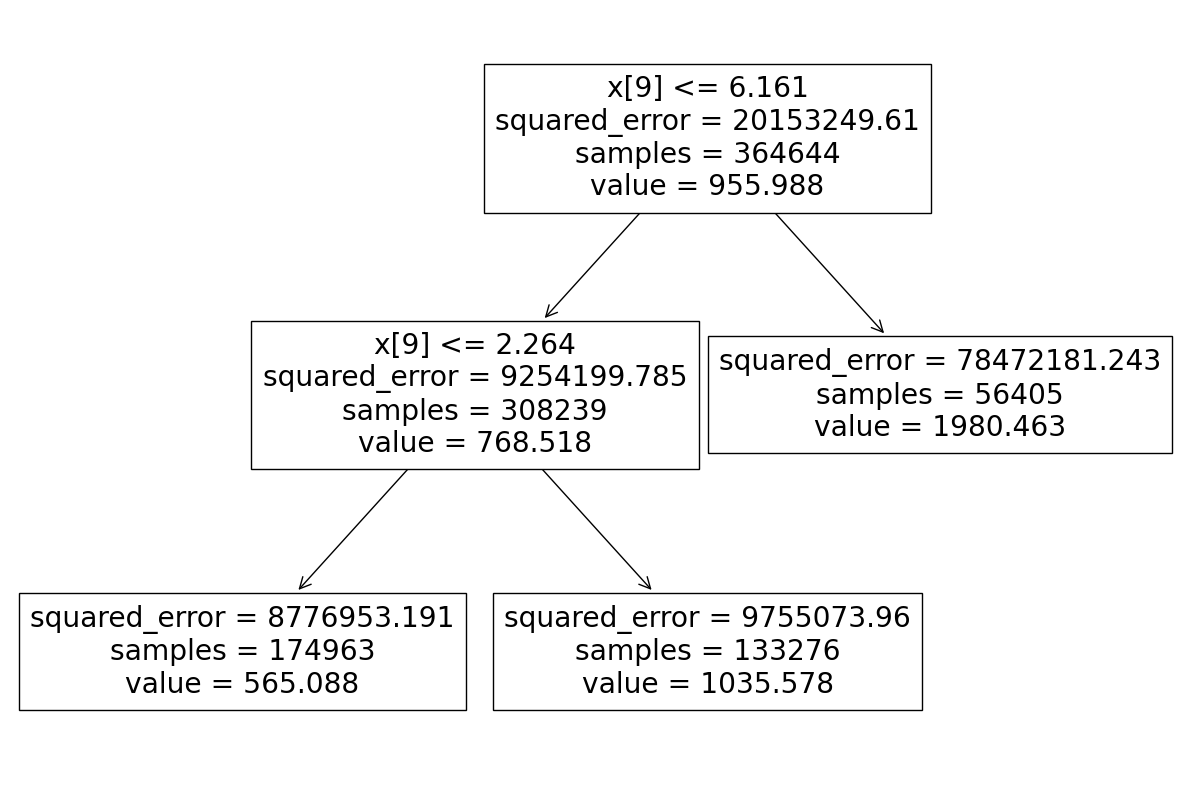

In [8]:
from sklearn import tree
fig = plt.figure(figsize=(15,10))
tree.plot_tree(optimal_DT.fit(X_train, y_train))

In [9]:
from sklearn.tree import export_text

tree_rules = export_text(optimal_DT, feature_names=list(X.columns))
print(tree_rules)

|--- distance <= 6.16
|   |--- distance <= 2.26
|   |   |--- value: [565.09]
|   |--- distance >  2.26
|   |   |--- value: [1035.58]
|--- distance >  6.16
|   |--- value: [1980.46]



In [10]:
from pycaret.regression import *

setup(data=df,  target='trip_duration', session_id=555, train_size=0.3, preprocess=True)

models()

,Description,Value
0,Session id,555
1,Target,trip_duration
2,Target type,Regression
3,Original data shape,"(729289, 11)"
4,Transformed data shape,"(729289, 11)"
5,Transformed train set shape,"(218786, 11)"
6,Transformed test set shape,"(510503, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [11]:
dt_reg = create_model(estimator='dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,583.2691,20343092.1687,4510.3317,-0.9043,0.6554,0.8019
1,580.3339,20001141.8941,4472.2636,-0.7159,0.6533,0.7796
2,547.8017,17106693.9198,4136.0239,-1.1336,0.6454,0.8719
3,580.4996,19768991.8015,4446.2334,-1.1905,0.6590,0.9135
4,546.5235,16889727.6646,4109.7114,-0.7782,0.6504,1.4361
5,563.1697,19012595.7751,4360.3435,-0.5643,0.6569,0.8415
6,551.2254,17528365.8509,4186.6891,-0.8652,0.6542,1.3734
7,560.6075,18538019.9032,4305.5801,-1.0638,0.6530,0.8712
8,608.2125,22597519.7832,4753.6849,-1.0085,0.6572,0.8086


CART

In [12]:
cart_model = DecisionTreeRegressor(random_state=17).fit(X_train, y_train)


y_pred = cart_model.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_pred), 
      '\nR^2= ',
      optimal_DT.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_pred),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_pred),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_pred))
      )

MSE =  18101592.258330707 
R^2=  0.02404237769719808 
MAE =  551.320470594688 
MAPE =  0.8354831244238334 
RMSE =  4254.596603478491


In [13]:
from sklearn.model_selection import GridSearchCV
cart_params = {'max_depth': range(1, 5),
               "min_samples_split": range(2, 6)}

cart_best_grid = GridSearchCV(cart_model,
                              cart_params,
                              cv=3,
                              verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [14]:
cart_best_grid.best_params_

{'max_depth': 2, 'min_samples_split': 2}

In [15]:
cart_final = DecisionTreeRegressor(**cart_best_grid.best_params_,
                                    random_state=17).fit(X_train, y_train)

y_pred = cart_final.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_pred), 
      '\nR^2= ',
      optimal_DT.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_pred),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_pred),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_pred))
      )

MSE =  9448560.09305221 
R^2=  0.02404237769719808 
MAE =  444.72598471611997 
MAPE =  0.9131256220688135 
RMSE =  3073.8510199832735


Ансамбли

In [16]:
from sklearn.ensemble import BaggingRegressor

bag_reg = BaggingRegressor().fit(X_train, y_train)

y_pred = bag_reg.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_pred), 
      '\nR^2= ',
      optimal_DT.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_pred),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_pred),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_pred))
      )

MSE =  10623129.081683416 
R^2=  0.02404237769719808 
MAE =  478.18617751511744 
MAPE =  0.7828385972343662 
RMSE =  3259.3142041974743


In [17]:
from sklearn.ensemble import GradientBoostingRegressor

grad_reg = GradientBoostingRegressor().fit(X_train, y_train)

y_pred = grad_reg.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_pred), 
      '\nR^2= ',
      optimal_DT.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_pred),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_pred),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_pred))
      )

MSE =  9312321.314152677 
R^2=  0.02404237769719808 
MAE =  416.0439707698245 
MAPE =  0.7887187323928947 
RMSE =  3051.60962676301


In [18]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

stack_clf = StackingRegressor(estimators=[
                                         ('en', DecisionTreeRegressor(max_depth=3)),
                                         ], final_estimator=LinearRegression()).fit(X_train, y_train)

y_pred = stack_clf.predict(X_test)

print('MSE = ', 
      mean_squared_error(y_test, y_pred), 
      '\nR^2= ',
      optimal_DT.score(X_test, y_test),
      '\nMAE = ',
        mean_absolute_error(y_test, y_pred),
      '\nMAPE = ',
      mean_absolute_percentage_error(y_test, y_pred),
      '\nRMSE = ',
      np.sqrt(mean_squared_error(y_test, y_pred))
      )

MSE =  9480050.573749328 
R^2=  0.02404237769719808 
MAE =  456.017989749817 
MAPE =  1.0049592971099068 
RMSE =  3078.9690764522675


CatBoostRegression

In [19]:
from catboost import CatBoostRegressor

CatBoostclf = CatBoostRegressor(iterations=2, depth=3).fit(X_train, y_train)

y_pred = CatBoostclf.predict(X_test)

print(mean_squared_error(y_test, y_pred))

Learning rate set to 0.5
0:	learn: 4468.2902600	total: 153ms	remaining: 153ms
1:	learn: 4456.9914817	total: 176ms	remaining: 0us
9478184.756574629


CART

In [ ]:
class Node:
    def __init__(self, depth: int) -> None:
        self.value = None                   # кол-во элементов
        self.left: Node = None
        self.right: Node = None
        self.depht: int = depth             # глубина вершины
    
    def get_left_node(self):
        if not self.left:
            self.left = Node(self.depht + 1)
            
    def get_right_node(self):
        if not self.right:
            self.right = Node(self.depht + 1)
            

class Split:
    def __init__(self, feature, threshold):
        self.feature = feature
        self.threshold = threshold

class CARTNodeData:
    def __init__(self, split, X, y) -> None:
        self.split: Split = split
        self.X = X
        self.y = y

In [ ]:
class CARTRegressor:
    def __init__(self, max_depht: 4):
        self.max_depht = max_depht
        self.tree_root: Node = Node(depth=0)
    
    def fit(self, X_tr, y_tr):
        self.__build_children(self.tree_root, X_tr, y_tr)
        
    def predict(self, X_test: pd.DataFrame):
        y_pred = []
        for index, feature in X_test.iterrows():
            depth = 0
            node = self.tree_root
            while(depth != self.max_depht):
                if feature[node.value.split.feature] > node.value.split.threshold:
                    node = node.right
                else:
                    node = node.left
                depth += 1
            y_pred.append(node.value.split.y.mean())
            
        return y_pred
    
    
    def __build_children(self, node: Node, X: pd.DataFrame, y: pd.DataFrame):
        split = self.__best_split(X, y)
        
        node.value = CARTNodeData(split, X, y)
        data_left_x, data_left_y, data_right_x, data_right_y = self.__split_data(X, y, split)
        
        if node.depht <= self.max_depht:
            self.__build_children(node.get_left_node(), data_left_x, data_left_y)
            self.__build_children(node.get_right_node(), data_right_x, data_right_y)
        
    def __best_split(self, X: pd.DataFrame, y: pd.DataFrame) -> Split:
        features = X.columns
        best_split = Split()
        best_gain = float('inf')
        
        for feature in features:
            thresholds = X[feature].unique()
            for threshold in thresholds:
                split = Split(feature, threshold)
                gain = self.__info_gain(X, y, split, self.calc_answer)
                if gain < best_gain:
                    best_split = split
                    best_gain = gain
        
        return best_split
    
    def __info_gain(self, X: pd.DataFrame, y: pd.DataFrame, split: Split) -> int:
        data_left_x, data_left_y, data_right_x, data_right_y = self.__split_data(X, y, split)
        G = data_left_y.count() / y.count() * self.__mse(y, data_left_y, data_right_y) + data_right_y.count() / y.count() * self.__mse(y, data_left_y, data_right_y)
        return G
    
    def __split_data(self, X: pd.DataFrame, y: pd.DataFrame, split: Split):
        X_left = X.transform(lambda x: x <= split.threshold).to_numpy()
        X_right = X.transform(lambda x: x > split.threshold).to_numpy()
        y_left = y.to_numpy().take(X_left.index.to_numpy())
        y_right = y.to_numpy().take(X_right.index.to_numpy())
        
        X_left = pd.DataFrame(X_left)
        X_right = pd.DataFrame(X_right)
        y_left = pd.DataFrame(y_left)
        y_right = pd.DataFrame(y_right)
        
        return X_left, y_left, X_right, y_right
        
    def __mse(self, y: pd.DataFrame, y_left: pd.DataFrame, y_right: pd.DataFrame) -> int:
        result = np.sum( (y - y_left.mean()) ** 2 + (y - y_right.mean()) ** 2 ) / y.count()
        return result